# Basics of mobile robotics Project

**Authors:**\
Badil Mujovi (274632)\
Aubin Mercier (316260)\
Mehmet Furkan Dogan (370234)\
Andrea Grillo (371099)

# Introduction

This project aims to combine vision, global and local navigation, and filtering to maneuver a Thymio robot in a predetermined environment.

Our environment consist of ...

Our implementation includes the following features:
- a
- b

# 1. Computer Vision

# 2. Path Planning

# 3. Filtering

# 4. Local Navigation

# 5. Motion control

# Complete code

# Conclusion

# SCAFFOLDING

### Installing dependencies

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyvisgraph
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install opencv-contrib-python
!{sys.executable} -m pip install tqdm

^C


### Constant Definition, libraries and submodules import

In [1]:
#  - - - CONSTANT DEFINITION - - -

USE_THYMIO = True

# sampling time
DT = .1

print("Constants defined")

#  - - - IMPORTS - - - 
import tdmclient.notebook
import time
import numpy as np

import local_navigation
import extended_kalman_filter
#from vision_thymio import *
import vision_thymio

print("Import executed successfully")

if USE_THYMIO:
    await tdmclient.notebook.start()
    print("Successfully connected to Thymio.")

Constants defined


c:\Users\andrea\Dropbox (Politecnico Di Torino Studenti)\Tirocinio Andrea Grillo\08 FIRMWARE\sensoriPaquitop\mobile-robotics-project\extended_kalman_filter.py:5: RuntimeWarning: invalid value encountered in multiply
  CAMERA_COVERED_COV = np.eye(3) * np.inf


Import executed successfully
Successfully connected to Thymio.


In [21]:
await tdmclient.notebook.stop()


In [15]:
# - - - RELOADING OF IMPORTED MODULES - - -
import importlib
importlib.reload(local_navigation)
importlib.reload(vision_thymio)
importlib.reload(extended_kalman_filter)

c:\Users\andrea\Dropbox (Politecnico Di Torino Studenti)\Tirocinio Andrea Grillo\08 FIRMWARE\sensoriPaquitop\mobile-robotics-project\extended_kalman_filter.py:5: RuntimeWarning: invalid value encountered in multiply
  CAMERA_COVERED_COV = np.eye(3) * np.inf


<module 'extended_kalman_filter' from 'c:\\Users\\andrea\\Dropbox (Politecnico Di Torino Studenti)\\Tirocinio Andrea Grillo\\08 FIRMWARE\\sensoriPaquitop\\mobile-robotics-project\\extended_kalman_filter.py'>

### Classes instantiation, helper functions to interact with the Thymio

In [2]:
# ISTANTIATE OBJECTS OF CLASSES

vis = vision_thymio.Vision_Thymio()
local_nav = local_navigation.Local_Navigation()
ekf = extended_kalman_filter.ExtendedKalmanFilter()

print("Classes defined correctly.")


# FUNCTION FOR THYMIO INTERACTION DEFINITION

@tdmclient.notebook.sync_var
def motor_go(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

@tdmclient.notebook.sync_var
def odometry():
    global motor_left_speed, motor_right_speed
    return (motor_left_speed, motor_right_speed)

print("Thymio functions defined correctly.")

Init Vision Thymio
Init Local Navigation
Init Extended Kalman Filter
Classes defined correctly.
Thymio functions defined correctly.


In [3]:
# TEST THAT THE THYMIO IS LISTENING TO US
motor_go(500,500)
time.sleep(1)
motor_stop()

### Perspective and scaling of the image, static obstacle detection

In [7]:
# init of the perspective and scaling of the image
vis.getPerspectiveAndScaling()

# get obstacles on the map
img = vis.getCorrectedImage()
staticObstacleList = vis.getVisibilityGraph(img)
print(staticObstacleList)


Can't find markers 3, 4, 5 and 6 for perspective transformation
[array([[560, 240],
       [494, 555],
       [658, 590],
       [719, 272]], dtype=int32)]


### Detection of the Thymio and the goal, optimal path computation

In [10]:
try:
    foundGoal = foundThymio = False
    goalPos = []
    thymioPos = []

    # try ten times to get thymio and goal position on the map, if not print error and exit
    for i in range(10):
        img = vis.getCorrectedImage()
        ids,corners = vis.detectArucoMarkers(img)

        if not foundGoal:
            foundGoal, goalPos = vis.getGoalPosition(ids, corners)
        if not foundThymio:
            foundThymio, thymioPos = vis.getThymioPos(ids,corners) 

        if foundGoal and foundThymio:
            break
        
        time.sleep(0.1)
    if not (foundGoal and foundThymio):
        raise Exception("cannot find thymio or goal")

    print(f"Found thymio and goal at iteration {i}")
    print(f"Position of the thymio: ", thymioPos[0][0]/vis.scalingFactor, thymioPos[0][1]/vis.scalingFactor, thymioPos[1])
    print(f"Position of the goal: {goalPos/vis.scalingFactor}")


    path = vis.getOptimalPath(thymioPos[0]/vis.scalingFactor, staticObstacleList.copy(), goalPos/vis.scalingFactor)

    # path reshaping to be used by the local navigation module
    path = list(map(tuple, path.reshape((path.shape[0], 2))))

    print("Computed optimal path: ", path)

    local_nav.define_path(path)

    #EKF state initialization
    initial_state = np.array([thymioPos[0][0],thymioPos[0][1], thymioPos[1], 0, 0])  # [x, y, theta, v, w]
    ekf.state_initialization(initial_state)


except Exception as e:
    print("ERROR - cannot find goal or thymio")
    print("foundThymio", foundThymio)
    print("foundGoal", foundGoal)


Unchecked Raise(exc=Call(func=Name(id='Exception', ctx=Load()), args=[Constant(value='cannot find thymio or goal')], keywords=[]))
Found thymio and goal at iteration 0
Position of the thymio:  1091.0 501.0 2.0344439357957027
Position of the goal: [274. 358.]
Computed optimal path:  [(1090.9675, 500.99875), (273.9625, 357.9725)]


In [11]:
for i in range(200):
    # Getting the position from the camera
    img = vis.getCorrectedImage()
    ids,corners = vis.detectArucoMarkers(img)
    foundThymio, thymioPos = vis.getThymioPos(ids,corners) 
    
    if foundThymio:
        ekf.set_mode(extended_kalman_filter.NORMAL)

    else:
        print("- - - CAMERA COVERED - - -")
        continue

        # If there is no camera input
        ekf.set_mode(extended_kalman_filter.KIDNAPPED)


    x,y, theta = thymioPos[0][0], thymioPos[0][1], thymioPos[1] # Position and orientation from the camera
    
    #control_input = np.array([v,w])
    #measurement = np.array([x, y, theta, v, w])

    # Perform prediction and update steps
    #ekf.predict(control_input, DT)
    #ekf.update(measurement)

    #x, y, theta, v, w = ekf.state
    print(x,y,theta)
    import math
    #wl,wr = local_nav.control((x,y,thymioPos[1]), sensor_data())
    v,w = local_nav.path_follow((x,y,theta))
    wl,wr= local_nav.differential_steering(v,w)

    
    # print(f"linear,angular velocities {(v,w)}") 
    # print(f"differential steering {(wl,wr)}") 
    
    motor_go(int(wl),int(wr))

    if abs(wl) > 4000 or abs(wr) > 4000:
        print(f"SATURATED")
        
    if (v,w) == (-1,-1):
        print("FINISHED")
        break


    time.sleep(DT)
motor_stop()

42.315 19.4525 2.0472637462686034
AAAMy pose is 42.315 19.4525 117.29957221133282
My objective is (1090.9675, 500.99875)
Distance is 1153.9319116158078
the angle i have to follow 24.664813863164138
DELTA ANGLE DEG: 92.6347583481687
42.315 19.41375 2.0407729652119047
AAAMy pose is 42.315 19.41375 116.92767785104051
My objective is (1090.9675, 500.99875)
Distance is 1153.94808287949
the angle i have to follow 24.66656233838569
DELTA ANGLE DEG: 92.26111551265484
42.315 19.41375 2.0439977852333
AAAMy pose is 42.315 19.41375 117.11244642795573
My objective is (1090.9675, 500.99875)
Distance is 1153.94808287949
the angle i have to follow 24.66656233838569
DELTA ANGLE DEG: 92.44588408957003
42.315 19.41375 2.0407729652119047
AAAMy pose is 42.315 19.41375 116.92767785104051
My objective is (1090.9675, 500.99875)
Distance is 1153.94808287949
the angle i have to follow 24.66656233838569
DELTA ANGLE DEG: 92.26111551265484
42.315 19.41375 2.0407729652119047
AAAMy pose is 42.315 19.41375 116.927677

In [ ]:
'''
get ınıtıal state from camera
get control ınput from ınıtıal state

for loop
 - get posıtıon from camera
 
 - update kalman fılter wıth data from camera

 - get posıtıon from kalman fılter

 - get control ınput from local navıgatıon controller

 - repeat

'''

In [17]:
motor_stop()

In [14]:
import importlib
importlib.reload(local_navigation)

local_nav = local_navigation.Local_Navigation([(0,0)])
vl,vr = 300,300
motor_go(vl,vr)
time.sleep(1)

for i in range(300):
      
      data = sensor_data()
      print(data)
      vl,vr = local_nav.obstacle_avoidance(sensor_data(), [vl,vr])
      motor_go(vl,vr)
      print(vl,vr)
      time.sleep(DT)

    
motor_stop()

init local nav
[0, 0, 0, 0, 0, 0, 0]
270 270
[0, 0, 0, 0, 0, 0, 0]
243 243
[0, 0, 0, 0, 0, 0, 0]
218 218
[0, 0, 0, 0, 0, 0, 0]
196 196
[0, 0, 0, 0, 0, 0, 0]
176 176
[0, 0, 0, 0, 0, 0, 0]
158 158
[0, 0, 0, 0, 0, 0, 0]
142 142
[0, 0, 0, 0, 0, 0, 0]
127 127
[0, 0, 0, 0, 0, 0, 0]
114 114
[0, 0, 0, 0, 0, 0, 0]
102 102
[0, 0, 0, 0, 0, 0, 0]
91 91
[0, 0, 0, 0, 0, 0, 0]
81 81
[0, 0, 0, 0, 0, 0, 0]
72 72
[0, 0, 0, 0, 0, 0, 0]
64 64
[0, 0, 0, 0, 0, 0, 0]
57 57
[0, 0, 0, 0, 0, 0, 0]
51 51
[0, 0, 0, 0, 0, 0, 0]
45 45
[0, 0, 0, 0, 0, 0, 0]
40 40
[0, 0, 0, 0, 0, 0, 0]
36 36
[0, 0, 0, 0, 0, 0, 0]
32 32
[0, 0, 0, 0, 0, 0, 0]
28 28
[1547, 2593, 0, 0, 0, 0, 0]
593 -543
[1547, 2593, 0, 0, 0, 0, 0]
1102 -1057
[1547, 2593, 0, 0, 0, 0, 0]
1560 -1520
[1547, 2593, 0, 0, 0, 0, 0]
1972 -1936
[1547, 2593, 0, 0, 0, 0, 0]
2343 -2311
[0, 0, 0, 0, 0, 0, 0]
2108 -2079
[0, 0, 0, 0, 0, 0, 0]
1897 -1871
[0, 0, 0, 0, 0, 0, 0]
1707 -1683
[0, 0, 0, 0, 0, 0, 0]
1536 -1514
[0, 0, 0, 0, 0, 0, 0]
1382 -1362
[0, 0, 0, 0, 0, 0, 

In [10]:

@tdmclient.notebook.sync_var
def obst_avoid():
    prox_horizontal = sensor_data()
    w_l = [6,  11, -10, -11, -6,  0,0]
    w_r = [-6, -11, -12.5,  11,  6, 0,0]

    # Scale factors for sensors and constant factor
    sensor_scale = 230

    y = [0,0]
    x = [0,0,0,0,0,0,0]
        
        
    for i in range(len(x)):
        # Get and scale inputs
        x[i] = prox_horizontal[i] / sensor_scale
        
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]

    # Set motor powers
    motor_go(int(115 + y[0]),int(115 + y[1]))
    time.sleep(DT)

for i in range(4000):
    obst_avoid()
motor_stop()


KeyboardInterrupt: 

In [ ]:
'''last_time = time.time()


state = 1
' ''
     States of the global FSM (finite state machine)
     
     1 -> computer vision and global path planning
     2 -> path following
     3 -> obstacle avoidance
     4 -> target reached
' ''
print(" - - - START MAIN CODE - - -")
#filtering

while True:
    # we have to estimate our pose regardless of our state
    # ToDo vision_position = vision.get_position()
    # ToDo motion data
    # ToDo pose_estimation = filtering (vision_position,data)
    # 
    pose_estimation = (10,15,0.23) # tuple (x,y,theta)
    
    
    if state == 1:
        print("MAIN FSM -> computer vision")
        # ToDo get nodes and edges from computer vision module
        
        nodes = [(1,2),(3,4),(5,6),(10,11)]

        global_nav = Global_Navigation(nodes)

        global_nav.add_edge((1,2),(3,4))
        global_nav.add_edge((1,2),(5,6))
        global_nav.add_edge((3,4),(10,11))
        global_nav.add_edge((10,11),(5,6))


        start_node = (1,2)
        target_node= (10,11)

        
        # next state -> path planning
        state = 2
        
    elif state == 2:
        print("MAIN FSM -> path planning")
        path = global_nav.path_planning(start_node,target_node)
        local_nav = Local_Navigation(path) 

        # next state -> path following
        state = 3
    elif state == 3:
        print("MAIN FSM -> path following")
        
        
        #if obstacle_present():
        #    state = 4
        #    continue
        state = 5
        
    elif state == 4:
        print("MAIN FSM -> obstacle avoidance")
        
        #if not obstacle_present():
        #    state = 3
        #    continue
        
        
        
    elif state == 5:
        print("MAIN FSM -> terminated")
        break
    
    # wait DT time - DT includes calculation time
    while True:
        
        act_time = time.time()
        if act_time - last_time >= DT:
            last_time = act_time
            break
            

print(" - - -    FINISHED     - - - ")
'''
print("skipped main code")

IN
eps: 0.1
iteration number 0
My pose is (0, 0, 0.7853981633974483)
My objective is (0, 0)
Distance is 0.0
reached objective number 0
My pose is (0, 0, 0.7853981633974483)
My objective is (1, 0)
Distance is 1.0
differential steering (469, -468)
iteration number 1
My pose is (0.0004419417382415922, 0.0004419417382415922, 0.7785259294677206)
My objective is (1, 0)
Distance is 0.999558155961181
differential steering (466, -464)
iteration number 2
My pose is (0.000886713537065729, 0.0008806420147124773, 0.7717096825494878)
My objective is (1, 0)
Distance is 0.9991136745721797
differential steering (462, -460)
iteration number 3
My pose is (0.001334266164575772, 0.0013161067213566932, 0.764948959483211)
My objective is (1, 0)
Distance is 0.9986666010606084
differential steering (458, -456)
iteration number 4
My pose is (0.0017845510185394895, 0.0017483422206880875, 0.7582433011095338)
My objective is (1, 0)
Distance is 0.9982169800628415
differential steering (454, -453)
iteration number 5

KeyboardInterrupt: 

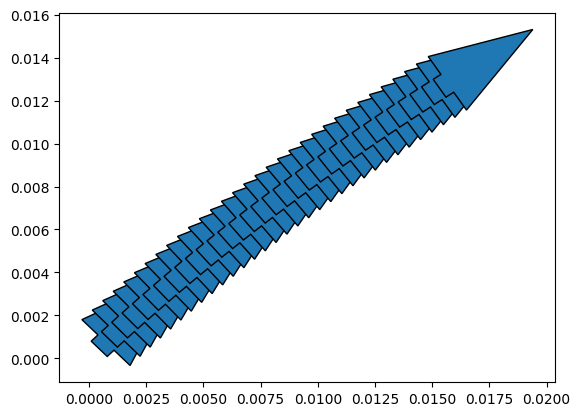

In [ ]:
import matplotlib.pyplot as plt 
import math 
nodes = [(0,0),(1,0),(3,10),(5,5),(10,2),(12,7)]


local_nav = local_navigation.Local_Navigation(nodes)
last_time = time.time()

#pose = []
#pose.append((0,0,45* math.pi / 180))
x = [0]
y = [0]
theta = 45 * math.pi / 180
for i in range(20000):
    
    print(f"iteration number {i}")
    v,w = local_nav.path_follow((x[-1],y[-1],theta))

    wl,wr= local_nav.differential_steering(v,w)
    print(f"differential steering {(wl,wr)}") 
    motor_go(wl,wr)
    if abs(wl) > 500 or abs(wr) > 500:
        print(f"SATURATED")
        break
    if (v,w) == (-1,-1):
        print("FINISHED")
        break
    #pose.append(   (pose[-1][0] + v * math.cos(pose[-1][2])/400, pose[-1][1] + v * math.sin(pose[-1][2])/400, pose[-1][2] + w/400) )
    x.append(x[-1] + v *  math.cos(theta)/400)
    y.append( y[-1] + v * math.sin(theta)/400)
    theta = theta + w/400
    
    
    plt.arrow(x[-1],y[-1],v*math.cos(theta)/600,v*math.sin(theta)/600)
    while True:

        act_time = time.time()
        if act_time - last_time >= DT:
            last_time = act_time
            break
            

for i in range(len(nodes)):
    plt.scatter(nodes[i][0],nodes[i][1])
    
plt.show()